In [1]:
import hist
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.analysis_tools import PackedSelection
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
# ---
# Sample: TTToSemiLeptonic: 1_280_000
fname = "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/120000/2A2F4EC9-F9BB-DF43-B08D-525B5389937E.root"
events = NanoEventsFactory.from_root(fname, entry_stop=1280000, schemaclass=NanoAODSchema).events()


print("Number of input events: {}".format(len(events)))

Number of input events: 1280000


# Objects: 

We will define the basic objects associated with top quark decay (2017).

<img src="Squema.png">
<img src="selected.png">
                   
                   

### Electron/Muon

|                 |    Electron       |    Muon     |
|-----------------|-------------------|-------------|
|  pT            | $\geq 30$         | $\geq 20$   |
| $|\eta|$        | $ < 2.4$          | $ < 2.4 $   |
| Electron ID     | CutBased $\geq 1$ |             |           
| Muon ID         |                   |  tight      |
| Muon Isolation  |                   |  $ > 0.15$  | 

A $\Delta R(e,\mu) > 0.4$ cut is included so as not to overlap between these objects.

The reconstructed objects will be stored in selected_object['electron'] and selected_object['muon'] as appropriate.







### FatJet


The information obtained from the FatJets will be used to identify tops and W.

[Click here](https://cmssdt.cern.ch/lxr/source/PhysicsTools/NanoAOD/python/nanoDQM_cfi.py)



#### Top Jet


|                           |    FatJet                 |
|---------------------------|---------------------------|
|  pT                      | $\geq 300$                | 
| $|\eta|$                  | $ < 2.4$                  | 
| Jet Id                    |  $ \geq 2 $               |               
| Top vs QCD Discriminator  | particleNet_TvsQCD $\geq 0.8$ | 


$\Delta R(e,top) > 0.8$ and $\Delta R(\mu,top) > 0.8$ are included so as not to overlap between these objects.

The reconstructed objects will be stored in selected_object['jetsTop'].



##### Jet Id
In nanoAOD format, jetId corresponds to the different working points.

- For 2016 samples:
    - jetId==1 means: pass loose ID, fail tight, fail tightLepVeto
    - jetId==3 means: pass loose and tight ID, fail tightLepVeto
    - jetId==7 means: pass loose, tight, tightLepVeto ID.

- For 2017 and 2018 samples:
    - jetId==2 means: pass tight ID, fail tightLepVeto
    - jetId==6 means: pass tight and tightLepVeto ID.

[Click here](https://twiki.cern.ch/twiki/bin/viewauth/CMS/JetID)

##### particleNet_TvsQCD: FatJets from top quarks (T) and QCD
values close to 1 indicate that the jet is more likely to come from a top quark, while values close to 0 indicate that the jet is more likely to come from the QCD.


#### W boson

|                                 |    FatJet                 |
|---------------------------------|---------------------------|
|  pT                            | $\geq 200$                | 
| $|\eta|$                        | $ < 2.4$                  | 
| Jet Id                          |  $ \geq 2 $               |                
| W vs QCD Discriminator          | particleNet_WvsQCD $ \geq 0.944$ |


$\Delta R(e,w) > 0.8$, $\Delta R(\mu,w) > 0.8$, and $\Delta R(top,w) > 0.8$ are included so as not to overlap between these objects.

The reconstructed objects will be stored in selected_object['jetsW'].


##### particleNet_TvsQCD: FatJets from top quarks (T) and QCD
values close to 1 indicate that the jet is more likely to come from a W boson, while values close to 0 indicate that the jet is more likely to come from the QCD.






### Jets

The information obtained from the Jets will be used to identify Jets and bjets.

#### Jets

|                                 |    Jet                 |
|---------------------------------|---------------------------|
|  pT                            | $\geq 20$                 | 
| $|\eta|$                        | $ < 2.5$                  | 
| Jet Id                          |  $ \geq 2 $               |                

The reconstructed objects will be stored in:
- selected_object['jets_noCleaned_against_boostedJets']: $\Delta R(e,jet) > 0.4$ and $\Delta R(\mu,jet) > 0.4$
- selected_object['jets_cleaned']: $\Delta R(e,jet) > 0.4$, $\Delta R(\mu,jet) > 0.4$, $\Delta R(top,jet) > 0.8$, and $\Delta R(w,jet) > 0.8$



#### bjets

We use the previously filtered Jets and add the DeepFlav criterion.


|                                 |    Jet                 |
|---------------------------------|---------------------------|
| $|\eta|$                        | $ < 2.5$                  | 
| btagDeepFlavB                   | Medium                    | 


The reconstructed objects will be stored in selected_object['jetsB'].


##### btagDeepFlavB: Deep Flavor algorithm

*** TLorentz objects: [Click here](https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.vector.LorentzVector.html)

In [3]:
# ---------------------------
# Complementary functions
# --------------------------.

def delta_r_mask(first: ak.Array, second: ak.Array, threshold: float) -> ak.Array:

    mval = first.metric_table(second)
    
    return ak.all(mval > threshold, axis=-1)

# -------------------
# calculate chi2
# -------------------
def chi2_test(topJet, wJet, top_sigma, w_sigma, pdg_masses):

    # PDG values
    top_mass_pdg = pdg_masses[0]
    w_mass_pdg = pdg_masses[1]
    
    
    t = (topJet.mass - top_mass_pdg) / top_sigma
    w = (wJet.mass - w_mass_pdg) / w_sigma
    

    chi2 = t**2 + w**2
    

    return chi2


In [4]:
selected_object = {'muon': [], 'electron': [],                       # Leptons
                    'jetsTop': [],                                    # FatJet
                    'jetsW': [],                                      # WJet
                    'jets_noCleaned_against_boostedJets': [],         # No overlap with Electrons and Muons
                    'jets_cleaned': [],                               # No overlap with FatJet, WJet, Electrons and Muons
                    'jetsB': []                                       # BJet
                   }
    

constants_as_fuction_wp_fatjet = {
                            "2016" : [3, 0.50, 0.73, 0.96], 
                            "2016APV" : [3, 0.49, 0.74, 0.96], 
                            "2017": [2, 0.58, 0.80, 0.97], 
                            "2018": [2, 0.58, 0.80, 0.97]
                        }

constants_as_fuction_wp_wjet = {
                            "2016" : [3, 0.68, 0.94, 0.97], 
                            "2016APV" : [3, 0.67, 0.93, 0.97], 
                            "2017": [2, 0.71, 0.94, 0.98], 
                            "2018": [2, 0.70, 0.94, 0.98]
                        }

constants_as_fuction_wp_jet = {
                            "2016" : [2.4, 3,  0.0480, 0.2489, 0.6377], 
                            "2016APV" : [2.4, 3, 0.0508, 0.2598, 0.6502], 
                            "2017": [2.5, 2, 0.0532, 0.3040, 0.7476], 
                            "2018": [2.5, 2, 0.0490, 0.2783, 0.7100]
                        } 


## Event preselection

In [5]:
##############################################
######  Definition of the objects ############
##############################################

# ------------
# Electrons
# ------------

good_electrons = (
    (events.Electron.pt >= 30)
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.cutBased >= 1)
)
# Events
electrons = events.Electron[good_electrons]
selected_object['electron'].append(electrons)
   
    

# ------------
# Muons
# ------------

good_muons = (
    (events.Muon.pt >= 20)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.tightId)
    & (events.Muon.pfRelIso04_all > 0.15)
    & (delta_r_mask(events.Muon, electrons, threshold = 0.4))   # Check that muons don't overlap with electrons (DeltaR > 0.4)
)
# Events
muons = events.Muon[good_muons]
selected_object['muon'].append(muons)

In [6]:
##########################################
############### Fat Jets #################
##########################################

# ---------------
# Top Jets
# ---------------

jet_id_top = constants_as_fuction_wp_fatjet["2017"][0]
pNet_id_top = constants_as_fuction_wp_fatjet["2017"][2]


# Select good fat jets
good_topjets = (
    (events.FatJet.pt >= 300)
    & (np.abs(events.FatJet.eta) <= 2.4)
    & (events.FatJet.particleNet_TvsQCD >= pNet_id_top)   # Medium   (Top vs QCD)
    & (events.FatJet.jetId >= jet_id_top)   # Medium
    & (delta_r_mask(events.FatJet, electrons, threshold=0.8))
    & (delta_r_mask(events.FatJet, muons, threshold=0.8))
)
# Events
tops = events.FatJet[good_topjets]
selected_object['jetsTop'].append(tops)


# ------------------
# W Jets
# ------------------


jet_id_w = constants_as_fuction_wp_wjet["2017"][0]
pNet_id_w = constants_as_fuction_wp_wjet["2017"][2]

good_wjets = (
    (events.FatJet.pt >= 200)
    & (np.abs(events.FatJet.eta) <= 2.4) #This is the recommendation for all the fat jets (there are not reconstructed forward fat jets)
    & (events.FatJet.jetId >= jet_id_w)   
    & (events.FatJet.particleNet_WvsQCD >= pNet_id_w)   # Medium  (W vs QCD)
    & (delta_r_mask(events.FatJet, electrons, threshold=0.8))
    & (delta_r_mask(events.FatJet, muons, threshold=0.8))
    & (delta_r_mask(events.FatJet, tops, threshold=0.8))
)
# Events
wjets = events.FatJet[good_wjets]
selected_object['jetsW'].append(wjets)


In [7]:
##########################################
################# Jets ###################
##########################################

jet_eta = constants_as_fuction_wp_jet["2017"][0]
jet_id = constants_as_fuction_wp_jet["2017"][1]


bjet_wp = constants_as_fuction_wp_jet["2017"][3]   # wp deppFlavour (medium)


good_jets_NC = (
    (events.Jet.pt >= 20)
    & (np.abs(events.Jet.eta) <= jet_eta) 
    & (events.Jet.jetId >= jet_id) 
    & (delta_r_mask(events.Jet, electrons, threshold=0.4))
    & (delta_r_mask(events.Jet, muons, threshold=0.4)) 
) 
# Events
jets_NC = events.Jet[good_jets_NC]
selected_object['jets_noCleaned_against_boostedJets'].append(jets_NC)



good_jets = (
    (good_jets_NC) 
    & (delta_r_mask(events.Jet, tops, threshold=0.8)) 
    & (delta_r_mask(events.Jet, wjets, threshold=0.8))
)    
# Events
jets = events.Jet[good_jets]
selected_object['jets_cleaned'].append(jets)



good_bjets = (
    (good_jets) 
    & (events.Jet.btagDeepFlavB >= bjet_wp)
)
# Events
bjets = events.Jet[good_bjets]
selected_object['jetsB'].append(bjets)


# Top's reconstruction 

- In order to reconstruct the top and wjets, a validity interval will be defined depending on each case considered.

- The chi-square criterion will be applied to define whether or not an event passes the top tagger.
    
$$ \chi^{2} = \left[\frac{m(t)_{(reconstructed)} - m(t)_{(pdg)}}{\sigma_{top}}\right]^2 + \left[\frac{m(w)_{(reconstructed)} - m(w)_{(pdg)}}{\sigma_{w}}\right]^2 < 5 $$ 


Where:
$m(t)_{(pdg)} = 173.1$;   $m(w)_{(pdg)} = 80.4$. $\sigma_{w}$ and $\sigma_{t}$ and the reconstructed masses depend on the case under consideration .


- We will work with some dictionaries that will be useful.
    
    * pdg_masses = [top_mass_pdg, w_mass_pdg, muon_mass_pdg, electron_mass_pdg]
    
    
    * results = {'top reconstructed', 'w reconstructed', 'top_topology_decay'= {0,1,2,3}, 'chi2'}
    
Where 0 = boosted top; 1 = Partially boosted; 2 = Hadronic top; 3 = leptonic top.
    
    
    * masses_sigmas_chi2 = {top_sigma, top_low, top_down, w_sigma, w_low, w_up, chi2}
    
Each value depends of the topology decay.

    * all_combinations_results = {'top reconstructed', 'w reconstructed', 'top_topology_decay'= {0,1,2,3}, 'chi2', 'top_AK4jets'}
    
    

### Boosted top: t

We use the information stored as jetsTop in our selected_object. With such objects, we determine the mass for each jetsTop and compare it with the range defined by:

##### Mass ranges

- $m_{t} = [100, 400]$


The function that perform the filters is defined by boosted_top(jetsTop,masses_sigmas_chi2, results). Results will be stored in results = {}.



### Partially-boosted top: t -> W b

We take the wjets and bjets previously defined from the FatJet and see if it meets the criterion that the reconstructed mass between these objects is in the mass window defined for the top. 


It is worth mentioning that a criterion based on the definition of a mass window will also be applied in order to correctly choose the w.


The function that perform the filters is defined by partially_boosted_top(jetsW, jetsB, masses_sigmas_chi2, all_combinations_results). 



Results will be stored in all_combinations_results = {}.

##### Mass ranges

- $m_{t} = [100, 300]$
- $m_{w} = [40, 200]$

##### $\sigma$ ranges

- $\sigma_{t} = 37.14 $
- $\sigma_{w} = 20.09 $

##### $\chi^{2}_{ref} == 5$

### Resolved hadronic top: t -> W(q q) b 
The idea is to perform the recontruction of the top using the information from 2 jets and 1 b-jet, where the two jets are the consequence of a hadronic decay of the W.


To select the two jets we consider events whose reconstructed mass of the two jets is in the window defined by mass mw(min) and mw(max). Events that pass the above filter are combined with the b-jet to reconstruct the top.


The function that perform the filters is defined by 
hadronic_top(jets_cleaned, jetsB, masses_sigmas_chi2, all_combinations_results). 



Results will be stored in all_combinations_results = {}.

##### Mass ranges

- $m_{t} = [100, 300]$
- $m_{w} = [40, 200]$

##### $\sigma$ ranges

- $\sigma_{t} = 35.02 $
- $\sigma_{w} = 24.98 $

##### $\chi^{2}_{ref} == 5$

### Resolved leptonic top: top -> W(l nu) b

Similar to the previous case, we perform the recontruction of the top using a lepton (l) plus neutrino (nu) in the final state, where l y nu rebuilt the W boson.


We consider events whose reconstructed mass of the lepton and nuetrino is in the mass window defined by mw(min) and mw(max). Events that pass the above filter are combined with the b-jet to reconstruct the top.


The function that perform the filters is defined by 
def single_leptonic_top(events, muon, electron, jetsB, masses_sigmas_chi2, pdg_masses, all_combinations_results). $\textbf{We use events as input since we have to work with the MET.}$


Results will be stored in all_combinations_results = {}.

##### Mass ranges

- $m_{t} = [100, 600]$
- $m_{w} = [40, 600]$


##### $\sigma$ ranges

- $\sigma_{t} = 120.8 $
- $\sigma_{w} = 127.2 $

##### $\chi^{2}_{ref} == 5$


# Results

Results that pass the criteria for building a top will be stored in the results{} dictionary.

$$ results = \left\{top; w; topology; \chi^{2}\right\} $$

- Top: Top reconstructed.
- Topology: Boosted top; Partially-boosted top; Resolved hadronic top; Resolved leptonic top.


$$ all\_combinations\_results =  {\cdots}$$


In [8]:
# Nomenclature: [top_sigma, top_low, top_down, w_sigma, w_low, w_up, chi2]
masses_sigmas_chi2 = {
                        "boosted top" : [37.14, 100, 400],
                        "Partially-boosted top" : [37.14, 100, 300, 20.09, 37.14, 20.09, 5],
                        "Resolved hadronic top" : [35.02, 100, 300, 24.98, 40, 200, 5],
                        "Resolved leptonic top" : [120.8, 100, 600, 127.2, 40, 600, 5]
                    }

pdg_masses = [173.1, 80.4, 0.10566, 0.511e-3]

# Results will be stored in results{}
result_boosted = {
          'top':[], 
          'w':[], 
          'top_topology_decay':[], 
          'chi2':[]
         }

result_hadronic = {
          'top':[], 
          'w':[], 
          'top_topology_decay':[], 
          'chi2':[]
         }

# Histos
histogram_boosted = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)


histogram_hadronic = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)

histogram_hadronic_without_chi2 = hist.Hist(
    hist.axis.Regular(
        bins=40, start=50, stop=450, name="mtop", label="$m_{top}$ [GeV]"
    ),
)

In [9]:
###################################
########### Boosted top ###########
###################################
def boosted_top(Tops, 
                masses_sigmas_chi2,
                result_boosted):
    
    
    jetsTop = Tops[ak.num(tops) == 1]
    
    
    top_mass_low = masses_sigmas_chi2["boosted top"][1]
    top_mass_up =  masses_sigmas_chi2["boosted top"][2]
    

    good_top_mass = (
        (jetsTop.mass > top_mass_low)
        & (jetsTop.mass < top_mass_up)
    )
    
    
    boosted_top = jetsTop[good_top_mass]   
    
    result_boosted['top'].append(boosted_top)
    result_boosted['w'].append(ak.Array([]))   
    result_boosted['top_topology_decay'].append(0)
    result_boosted['chi2'].append(0.0000001)

Text(0, 0.5, 'Events')

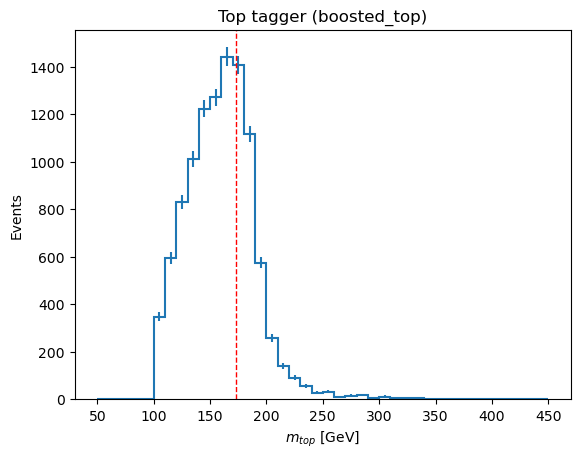

In [10]:
# Check the boosted tops: FatJets are identified as Top Jets
boosted_top(selected_object['jetsTop'][0], masses_sigmas_chi2, result_boosted)

histogram_boosted.fill(mtop=ak.fill_none(ak.flatten(result_boosted['top'][0].mass), False)).plot1d();
plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger (boosted_top)')
plt.ylabel('Events')

In [11]:
###################################
#########  Hadronic top ###########
###################################
def hadronic_top(jets_cleaned,         
                 masses_sigmas_chi2,
                 result_hadronic):

    trijets = jets_cleaned[ak.num(jets_cleaned) == 3]

    
    top_sigma = masses_sigmas_chi2["Resolved hadronic top"][0]
    top_mass_low = masses_sigmas_chi2["Resolved hadronic top"][1]
    top_mass_up = masses_sigmas_chi2["Resolved hadronic top"][2]
    

    w_sigma = masses_sigmas_chi2["Resolved hadronic top"][3]    
    w_mass_low = masses_sigmas_chi2["Resolved hadronic top"][4]
    w_mass_up = masses_sigmas_chi2["Resolved hadronic top"][5]

    
    
    # 2 jets will rebuild the w and the third will correspond to the b-jet.
    jet_1 = ak.pad_none(trijets, 2)[:, 0]
    jet_2 = ak.pad_none(trijets, 2)[:, 1]
    jet_3 = ak.pad_none(trijets, 2)[:, 2]


    # 3 jets will rebuild the top
    trijet = jet_1 + jet_2 + jet_3
    
    
    good_tops = (
            (trijet.mass > top_mass_low)
            & (trijet.mass < top_mass_up)
    )       
    
    good_trijet = ak.mask(trijet, good_tops)
    
 
    #   The main idea is to reconstruct the top mass using three jets:
    #     - two jets will be used to reconstruct a W particle (W boson).
    #     - third jet will correspond to a b-jet.

    max_wp = np.maximum(
        jet_1.btagDeepFlavB,
        np.maximum(jet_2.btagDeepFlavB, jet_3.btagDeepFlavB),
    )
       

    dijet = ak.where((jet_1.btagDeepFlavB > bjet_wp) & (jet_1.btagDeepFlavB == max_wp),                # Does jet_1 pass the bjet_wp criteria?
                    
                        jet_2 + jet_3,                      # Yes, jet_1 does, so wjet = jet_2 + jet_3 *
                
                        (ak.where((jet_2.btagDeepFlavB > bjet_wp) & (jet_2.btagDeepFlavB == max_wp),   # No, jet_1 does not. Therefore, we ask if jet 2 passes the bjet_wp criteria.
                    
                        jet_1 + jet_3,                     # Yes, jet_2 does, so wjet = jet_1 + jet_3 *
                                  
                        jet_1 + jet_2,                     # No, jet_2 does not, so wjet = jet_1 + jet_2 *
                        
                        )
                ),
    )

    
    good_w = (
            (w_mass_low < dijet.mass)
            & (dijet.mass < w_mass_up)
    )  
    
    good_dijet = ak.mask(dijet, good_w)

    
    
    # ----------------------
    # chi2 criteria
    # ----------------------
    chi2_ref = masses_sigmas_chi2["Resolved hadronic top"][6]
    chi2_cal = chi2_test(good_trijet, good_dijet, top_sigma, w_sigma, pdg_masses)
   
    
    good_chi2 = chi2_cal < chi2_ref
    

    top_chi2 = ak.mask(good_trijet,good_chi2)
    w_chi2 = ak.mask(good_dijet,good_chi2)


    result_hadronic['top'].append(top_chi2)
    result_hadronic['w'].append(w_chi2)   
    result_hadronic['top_topology_decay'].append(2)
    result_hadronic['chi2'].append(chi2_cal)   



Text(0, 0.5, 'Events')

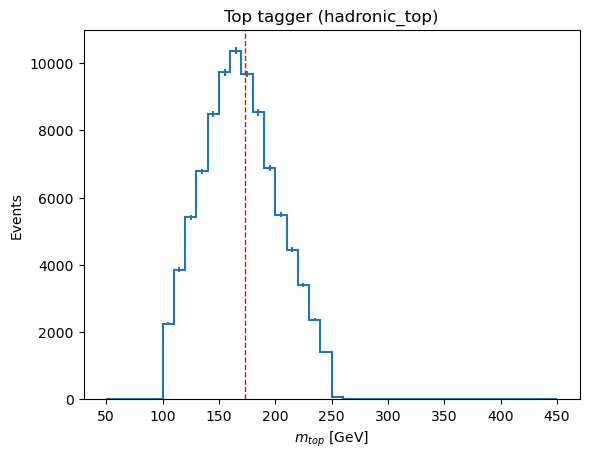

In [12]:
# Check the hadronic tops
hadronic_top(selected_object['jets_cleaned'][0], masses_sigmas_chi2, result_hadronic)


histogram_hadronic.fill(mtop=ak.fill_none(result_hadronic['top'][0].mass, False)).plot1d()

plt.axvline(173.1, color='r', linestyle='dashed', linewidth=1)
plt.title('Top tagger (hadronic_top)')
plt.ylabel('Events')

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2353434cd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

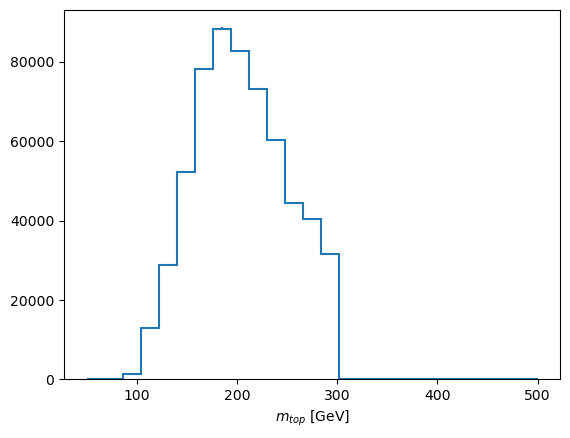

In [19]:
histogram_hadronic.fill(mtop=ak.fill_none(result_hadronic_without_chi2['top'][0].mass, False)).plot1d()